In [1]:
import os
import numpy as np
from functools import partial
import math
from tqdm import tqdm
import time as time

import torch
M1 = False

if M1:
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
else:
    os.environ["CUDA_VISIBLE_DEVICES"]="1"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.is_available():
        print(torch.cuda.is_available())
        print(torch.cuda.device_count())
        print(torch.cuda.current_device())
        print(torch.cuda.get_device_name(torch.cuda.current_device()))


from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from torchmetrics.functional import structural_similarity_index_measure 
from torchmetrics.functional import peak_signal_noise_ratio 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy.io as sio
from astropy.io import fits
import skimage as ski

import large_scale_UQ as luq
from large_scale_UQ.utils import to_numpy, to_tensor
from convex_reg import utils as utils_cvx_reg



True
1
0
NVIDIA A100-PCIE-40GB
Using device: cuda


In [2]:
# Optimisation options for the MAP estimation
options = {"tol": 1e-5, "iter": 15000, "update_iter": 4999, "record_iters": False}
# Save param
repo_dir = '/disk/xray0/tl3/repos/large-scale-UQ'
base_savedir = '/disk/xray0/tl3/outputs/large-scale-UQ/def_UQ_results/CRR'
save_dir = base_savedir + '/vars/'
savefig_dir = base_savedir + '/figs/'

# Define my torch types (CRR requires torch.float32)
myType = torch.float32
myComplexType = torch.complex64

# CRR load parameters
sigma_training = 5
t_model = 5
CRR_dir_name = '/disk/xray0/tl3/repos/convex_ridge_regularizers/trained_models/'
# CRR parameters
reg_param = 5e4
mu = 20


img_name = 'M31'
# It could be any of these ['M31', 'W28', 'CYN', '3c288']


# Load models and data

In [3]:
# %%
# Load image and mask
img, mat_mask = luq.helpers.load_imgs(img_name, repo_dir)

# Aliases
x = img
ground_truth = img

torch_img = torch.tensor(
    np.copy(img), dtype=myType, device=device).reshape((1,1) + img.shape
)

phi = luq.operators.MaskedFourier_torch(
    shape=img.shape, 
    ratio=0.5 ,
    mask=mat_mask,
    norm='ortho',
    device=device
)


# Define X Cai noise level
sigma = 0.0024

y = phi.dir_op(torch_img).detach().cpu().squeeze().numpy()

# Generate noise
rng = np.random.default_rng(seed=0)
n = rng.normal(0, sigma, y[y!=0].shape)
# Add noise
y[y!=0] += n

# Observation
torch_y = torch.tensor(np.copy(y), device=device, dtype=myComplexType).reshape((1,) + img.shape)
x_init = torch.abs(phi.adj_op(torch_y))


# %%
# Define the likelihood
g = luq.operators.L2Norm_torch(
    sigma=sigma,
    data=torch_y,
    Phi=phi,
)
# Lipschitz constant computed automatically by g, stored in g.beta

# Define real prox
f = luq.operators.RealProx_torch()



INSTRUME                                                                         [astropy.io.fits.card]


In [4]:
# %%
# Load CRR model
torch.set_grad_enabled(False)
torch.set_num_threads(4)

exp_name = f'Sigma_{sigma_training}_t_{t_model}/'
model = utils_cvx_reg.load_model(CRR_dir_name + exp_name, 'cuda:0', device_type='gpu')

print(f'Numbers of parameters before prunning: {model.num_params}')
model.prune()
print(f'Numbers of parameters after prunning: {model.num_params}')

# L_CRR = model.L.detach().cpu().squeeze().numpy()
# print(f"Lipschitz bound {L_CRR:.3f}")

# [not required] intialize the eigen vector of dimension (size, size) associated to the largest eigen value
model.initializeEigen(size=100)
# compute bound via a power iteration which couples the activations and the convolutions
model.precise_lipschitz_bound(n_iter=100)
# the bound is stored in the model
L_CRR = model.L.data.item()
print(f"Lipschitz bound {L_CRR:.3f}")


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 - linear_spline activation functions
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
Numbers of parameters before prunning: 13610
---------------------
 PRUNNING 
 Found 22 filters with non-vanishing potential functions
---------------------
Numbers of parameters after prunning: 4183
Lipschitz bound 0.770


# Optimisation

In [5]:

# Prior parameters
lmbd = reg_param

# Compute stepsize
alpha = 0.98 / (g.beta + mu * lmbd * L_CRR)

# initialization
x_hat = torch.clone(x_init)
z = torch.clone(x_init)
t = 1

# Accelerated gradient descend
for it_2 in range(options['iter']):
    x_hat_old = torch.clone(x_hat)
    
    x_hat = z - alpha *(
        g.grad(z) + lmbd * model(mu * z)
    )
    # Reality constraint
    x_hat = f.prox(x_hat)
    
    t_old = t 
    t = 0.5 * (1 + math.sqrt(1 + 4*t**2))
    z = x_hat + (t_old - 1)/t * (x_hat - x_hat_old)

    # relative change of norm for terminating
    res = (torch.norm(x_hat_old - x_hat)/torch.norm(x_hat_old)).item()

    if res < options['tol']:
        print("[GD] converged in %d iterations"%(it_2))
        break

    if it_2 % options['update_iter'] == 0:
        print(
            "[GD] %d out of %d iterations, tol = %f" %(            
                it_2,
                options['iter'],
                res,
            )
        )



[GD] 0 out of 15000 iterations, tol = 0.074123
[GD] converged in 1032 iterations


In [6]:
np_x_hat = to_numpy(x_hat)
np_x = np.copy(x)

# Evaluate performance
print('PSNR: ', psnr(np_x, np_x_hat, data_range=np_x.max()-np_x.min()))
print('SNR: ', luq.utils.eval_snr(x, np_x_hat))


PSNR:  55.26011777146593
SNR:  32.82


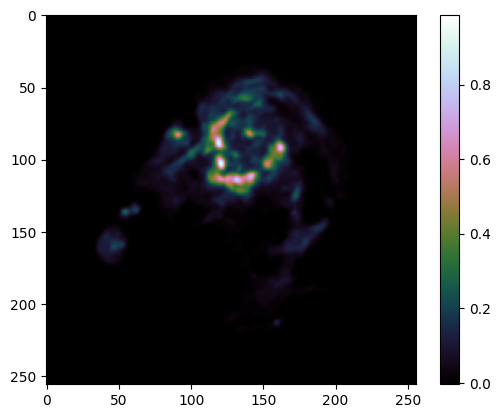

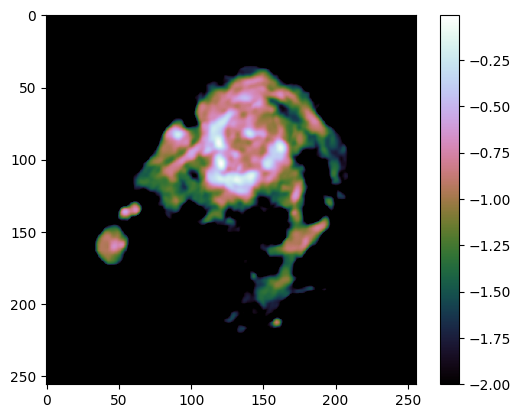

In [37]:
plt.figure()
plt.imshow(np_x_hat, cmap='cubehelix')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.log10(abs(np_x_hat)), cmap='cubehelix', vmin=-2)
plt.colorbar()
plt.show()


# MAP-based pixel UQ

In [8]:
### MAP-based UQ

# Parameters
alpha_prob = 0.01
superpix_size = 8

# LCI compute parameters
LCI_iters = 200  # Max iterations
LCI_tol = 1e-4
LCI_bottom = -10
LCI_top = 10

# Clipping values for MAP-based LCI. Set as None for no clipping
clip_high_val = 1.
clip_low_val = 0.


In [9]:

# Function handle for the potential
def _fun(_x, model, mu, lmbd):
    return (lmbd / mu) * model.cost(mu * _x) + g.fun(_x)

# Evaluation of the potential
fun = partial(_fun, model=model, mu=mu, lmbd=lmbd)
# Evaluation of the potential in numpy
fun_np = lambda _x : fun(luq.utils.to_tensor(_x, dtype=myType)).item()

# Compute HPD region bound
N = np_x_hat.size
tau_alpha = np.sqrt(16*np.log(3/alpha_prob))
gamma_alpha = fun(x_hat).item() + tau_alpha*np.sqrt(N) + N


-----------------------
Updating spline coefficients for the reg cost
 (the gradient-step model is trained and intergration is required to compute the regularization cost)
-----------------------


In [10]:

# Compute upper and lower uncertainty bounds
error_p, error_m, mean = luq.map_uncertainty.create_local_credible_interval(
    x_sol=np_x_hat,
    region_size=superpix_size,
    function=fun_np,
    bound=gamma_alpha,
    iters=LCI_iters,
    tol=LCI_tol,
    bottom=LCI_bottom,
    top=LCI_top,
)

# Clip plot values
error_length = luq.utils.clip_matrix(
    np.copy(error_p), clip_low_val, clip_high_val
) - luq.utils.clip_matrix(
    np.copy(error_m), clip_low_val, clip_high_val
)

Calculating credible interval for superpxiel:  (256, 256)
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.


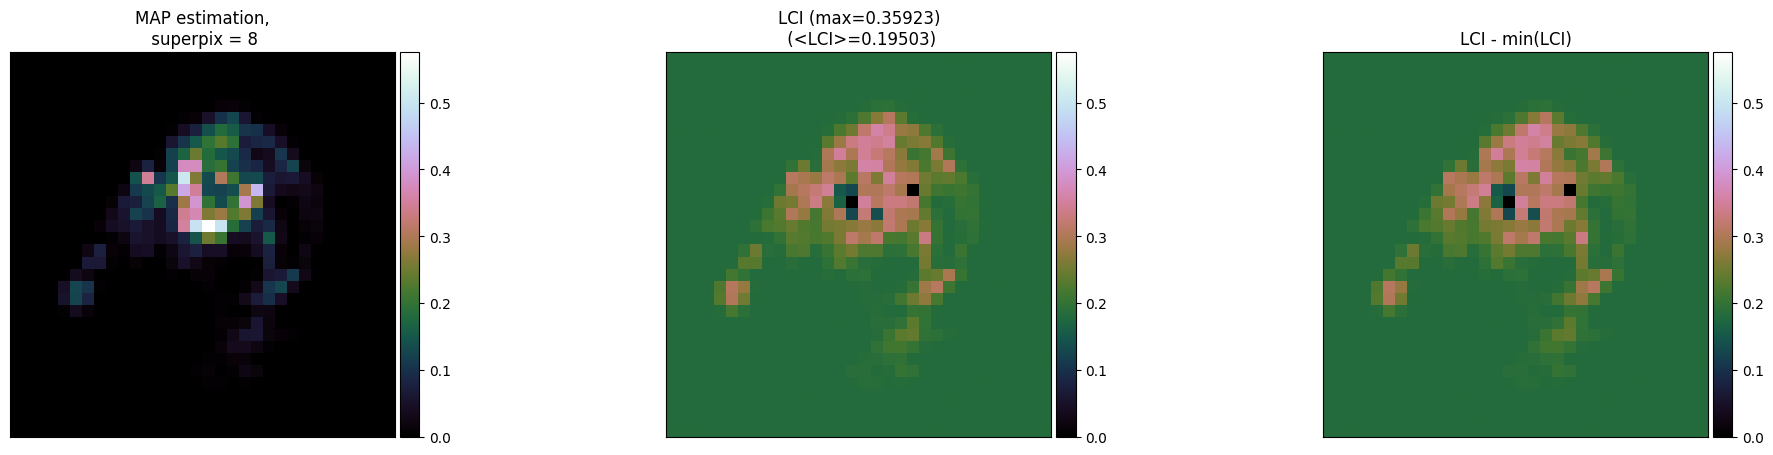

In [11]:

# Plot UQ
cmap = 'cubehelix'
vmin = np.min((mean, error_length))
vmax = np.max((mean, error_length))

fig = plt.figure(figsize=(24,5))

plt.subplot(131)
ax = plt.gca()
ax.set_title('MAP estimation,\n superpix = {:d}'.format(superpix_size))
im = ax.imshow(mean, cmap=cmap, vmin=vmin, vmax=vmax)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_yticks([]);ax.set_xticks([])

plt.subplot(132)
ax = plt.gca()
ax.set_title('LCI (max={:.5f})\n (<LCI>={:.5f})'.format(
        np.max(error_length), np.mean(error_length)
    )
)
im = ax.imshow(error_length, cmap=cmap, vmin=vmin, vmax=vmax)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_yticks([]);ax.set_xticks([])

plt.subplot(133)
ax = plt.gca()
ax.set_title('LCI - min(LCI)')
im = ax.imshow(error_length - np.min(error_length), cmap=cmap, vmin=vmin, vmax=vmax)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_yticks([]);ax.set_xticks([])

plt.show()



# New pixel UQ method

In [61]:
# Define the wavelet parameters
wavs_list = ['db8']
levels = 4

# Define the wavelet dict
# Define the l1 norm with dict psi
Psi = luq.operators.DictionaryWv_torch(wavs_list, levels)




In [62]:
# Clone MAP estimation and cast type for wavelet operations
torch_img = torch.clone(x_hat).to(torch.float64)


In [63]:

wav_img = Psi.dir_op(torch_img)


In [64]:
len(wav_img[0][4])

3

In [65]:
wav_img[0][1][2].shape

torch.Size([1, 1, 30, 30])

<function matplotlib.pyplot.show(close=None, block=None)>

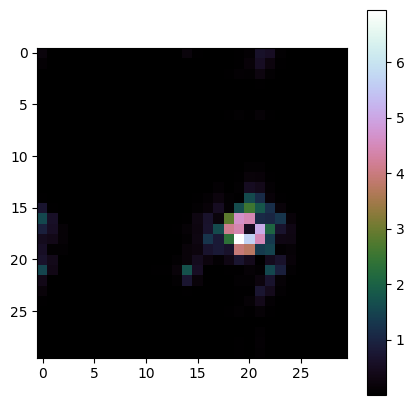

In [66]:
plt.figure(figsize=(5,5))
plt.imshow(abs(to_numpy(wav_img[0][0])), cmap=cmap)
plt.colorbar()
plt.show

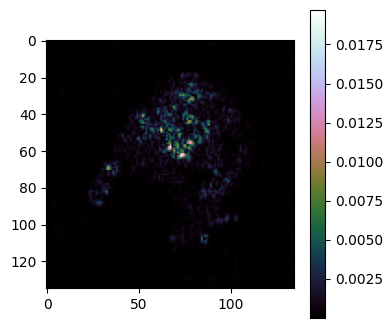

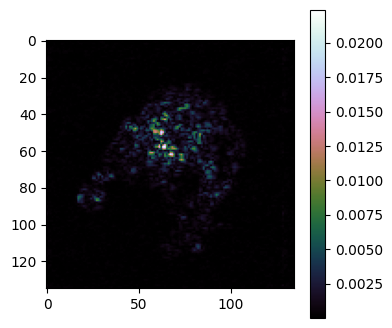

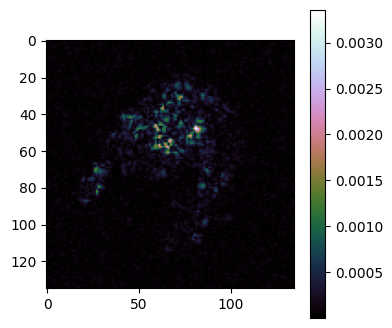

In [195]:
wav_scale = 4
for it in range(len(wav_img[0][wav_scale])):
    plt.figure(figsize=(4,4))
    plt.imshow(abs(to_numpy(wav_img[0][wav_scale][it])), cmap=cmap)
    plt.colorbar()
    plt.show



In [72]:
if type(Psi) is luq.operators.DictionaryWv_torch:
    print('hello')

hello


In [73]:
type(Psi)

large_scale_UQ.operators.DictionaryWv_torch

In [177]:


class Operation2WaveletCoeffs_torch(torch.nn.Module):
    """This class helps to apply operations to wavelet coefficients.

    """

    def __init__(self, Psi=None):
        """Initialise

        Args:
            Psi (Linear operator): Wavelet transform class


        """
        super().__init__()

        if Psi is None:
            self.Psi = luq.empty.Identity()
            self.levels = 0
            self.num_wavs = 0
        else:
            self.Psi = Psi
            if type(self.Psi) is luq.operators.Wavelets_torch:
                # Number of wavelets used in the dictionary
                self.num_wavs = 1

            elif type(self.Psi) is luq.operators.DictionaryWv_torch:
                # Number of wavelets used in the dictionary
                self.num_wavs = len(self.Psi.wavelet_list)

            # Set the number of wavelets scales
            self.levels = self.Psi.levels


    def _apply_op_to_coeffs(self, coeffs, op):
        """Applies operation to all coefficients in ptwt structure.
        
        """
        # Iterate over the wavelet dictionaries
        for wav_i in range(self.num_wavs):
            # Apply op over the low freq approx
            coeffs[wav_i][0] = op(coeffs[wav_i][0])
            # Iterate over the wavelet decomp and apply op
            for it1 in range(1, len(coeffs[0])):
                coeffs[wav_i][it1] = tuple([op(elem) for elem in  coeffs[wav_i][it1]])

        return coeffs

    def _apply_op_to_coeffs_at_level(self, coeffs, level, op):
        """Applies operation to all coefficients at a given level in ptwt structure.
        
            level (int or None): Level of wavelet decomposition to apply the operation.
                If the level is None, the operation is applied to all existing levels.
        """
        if level is None:
            coeffs = self._apply_op_to_coeffs(coeffs, op)
        else:
            # Iterate over the wavelet dictionaries
            for wav_i in range(self.num_wavs):
                if level == 0:
                    # Apply op over the low freq approx
                    coeffs[wav_i][0] = op(coeffs[wav_i][0])
                elif level > 0  and level <= len(coeffs[0]):
                    # Iterate over the wavelet decomp and apply op
                    coeffs[wav_i][level] = tuple([op(elem) for elem in  coeffs[wav_i][level]])
                else:
                    raise ValueError(
                        'The level requested is higher than the one used in the wavelet decomposition.'
                    )

        return coeffs
    
    def _op_to_two_coeffs(self, coeffs1, coeffs2, op):
        """Applies operation to two set of coefficients in ptwt structure.

        Saves result in coeffs1.

        Args:

            coeffs1 (List[Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]]):
                First set of wavelet coefficients
            coeffs2 (List[Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]]):
                Second set of wavelet coefficients
            op (function): Operation to apply
        
        Returns:

            coeffs (List[Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]]): 
                Resulting coefficients
        """
        # Iterate over the wavelet dictionaries
        for wav_i in range(self.num_wavs):
            # Apply op over the low freq approx
            coeffs1[wav_i][0] = op(coeffs1[wav_i][0], coeffs2[wav_i][0])
            # Iterate over the wavelet decomp and apply op
            for it1 in range(1, len(coeffs1[0])):
                coeffs1[wav_i][it1] = tuple(
                    [op(elem1, elem2) for elem1, elem2 in zip(
                        coeffs1[wav_i][it1], coeffs2[wav_i][it1]
                    )]
                )
        return coeffs1

    def _get_max_abs_coeffs(self, coeffs):
        """Get the max abs value of all coefficients

        Args:

            coeffs (List[Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]]):
                Set of wavelet coefficients

        Returns:

            max abs value of all coefficients
        """
        max_val = []
        # Iterate over the wavelet dictionaries
        for wav_i in range(self.num_wavs):
            # Apply op over the low freq approx
            max_val.append(torch.max(torch.abs((coeffs[wav_i][0]))))
            # Iterate over the wavelet decompositions
            for it1 in range(1, len(coeffs[0])):
                for it2 in range(len(coeffs[wav_i][it1])):
                    max_val.append(torch.max(torch.abs((coeffs[wav_i][it1][it2]))))

        # Apply operation to the coefficients
        return torch.max(torch.tensor(max_val)).item()    


    def threshold_coeffs(self, coeffs, thresh, level=None):
        """Threshold coefficients and put to zero

        Args:

            coeffs (ptwt.coeffs): Wavelet coefficients
            thresh (double): Threshold
            level (int or None): Level of wavelet decomposition to apply the operation.
                If the level is None, the operation is applied to all existing levels.

        Returns:

            Thresholded coefficients (ptwt.coeffs)
        """
        # Define the element-wise operation
        op = lambda _x: self._threshold(_x, thresh=thresh)
        # Apply operation to the coefficients
        return self._apply_op_to_coeffs_at_level(coeffs, level, op)
    
    def full_op_threshold_img(self, img, thresh, level=None):
        """Threshold image wavelet coefficients

        Args:

            img (torch.Tensor): Image [H,W]
            thresh (double): Threshold
            level (int or None): Level of wavelet decomposition to apply the operation.
                If the level is None, the operation is applied to all existing levels.

        Returns:

            Thresholded img (torch.Tensor)
        """
        return self.adj_op(self.threshold_coeffs(
                    self.dir_op(img), thresh=thresh, level=level
                )).squeeze()

    def full_op_add_img(self, img, val, level=None):
        """Add val to image wavelet coefficients at given level

        Args:

            img (torch.Tensor): Image [H,W]
            thresh (double): Threshold
            level (int or None): Level of wavelet decomposition to apply the operation.
                If the level is None, the operation is applied to all existing levels.

        Returns:

            Modified img (torch.Tensor)
        """
        return self.adj_op(self.add_value_at_level(
                    self.dir_op(img), level=level, val=val
                )).squeeze()

    def full_op_mult_img(self, img, val, level=None):
        """Multiply val to image wavelet coefficients at given level

        Args:

            img (torch.Tensor): Image [H,W]
            thresh (double): Threshold
            level (int or None): Level of wavelet decomposition to apply the operation.
                If the level is None, the operation is applied to all existing levels.

        Returns:

            Modified img (torch.Tensor)
        """
        return self.adj_op(self.mult_value_at_level(
                    self.dir_op(img), level=level, val=val
                )).squeeze()
    
    def add_value_at_level(self, coeffs, level, val):
        """Threshold coefficients and put to zero

        Args:

            coeffs (ptwt.coeffs): Wavelet coefficients
            level (int or None): Level of wavelet decomposition to apply the operation.
                If the level is None, the operation is applied to all existing levels.
            val (double): value

        Returns:

            Modified coefficients (ptwt.coeffs)
        """
        # Define the element-wise operation
        op = lambda _x: _x + val
        # Apply operation to the coefficients
        return self._apply_op_to_coeffs_at_level(coeffs, level, op)

    def mult_value_at_level(self, coeffs, level, val):
        """Threshold coefficients and put to zero

        Args:

            coeffs (ptwt.coeffs): Wavelet coefficients
            level (int or None): Level of wavelet decomposition to apply the operation.
                If the level is None, the operation is applied to all existing levels.
            val (double): value

        Returns:

            Modified coefficients (ptwt.coeffs)
        """
        # Define the element-wise operation
        op = lambda _x: _x * val
        # Apply operation to the coefficients
        return self._apply_op_to_coeffs_at_level(coeffs, level, op)

    def _threshold(self, x, thresh):
        """Threshold coefficients

        Args:

            x (torch.Tensor): tensor to operate on
            thresh (double): Threhsold

        Returns:

            Thresholded version of x
        """
        # Replaced the use of torch.sign() to add complex value support
        abs_x = torch.abs(x)
        return torch.maximum(
                torch.zeros_like(abs_x), abs_x - thresh
            ) * torch.nan_to_num(x / abs_x, nan=0.0)
     
    def dir_op(self, x):
        """Evaluates the forward regularisation operator

        Args:

            x (torch.Tensor): Tensor to forward transform

        Returns:

            Forward regularisation operator applied to x
        """
        return self.Psi.dir_op(x)

    def adj_op(self, x):
        """Evaluates the forward adjoint regularisation operator

        Args:

            x (torch.Tensor): Tensor to adjoint transform

        Returns:

            Forward adjoint regularisation operator applied to x
        """
        return self.Psi.adj_op(x)


# Threshold coefficients

In [178]:


oper2wavelet = Operation2WaveletCoeffs_torch(Psi=Psi)


In [184]:
thresh = 0.05


thresh_img = oper2wavelet.full_op_threshold_img(torch_img, thresh)

print('gamma_alpha: ', gamma_alpha)
print('thresholded image: ', fun_np(torch_img.squeeze()))
print('thresholded image: ', fun_np(thresh_img.squeeze()))


gamma_alpha:  100600.93884931403
thresholded image:  32619.361328125
thresholded image:  153514.125


/disk/xray0/tl3/repos/large-scale-UQ/large_scale_UQ/utils.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(


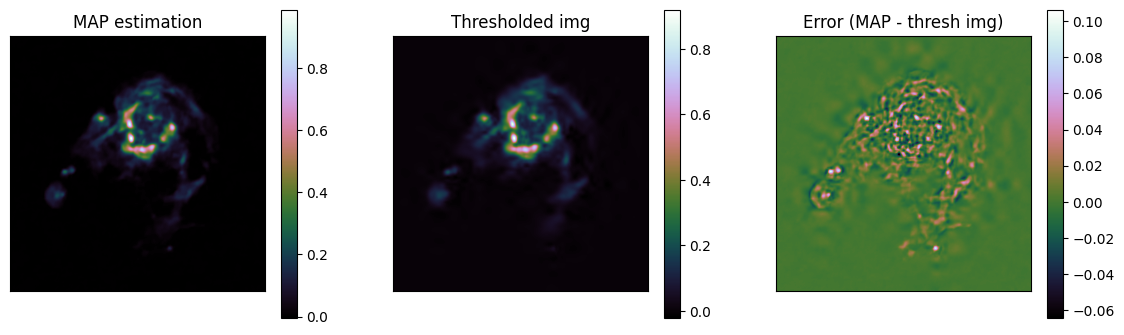

In [185]:

plt.figure(figsize=(14,4))

plt.subplot(131)
plt.imshow(to_numpy(torch_img), cmap=cmap)
plt.colorbar()
plt.title('MAP estimation')
ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

plt.subplot(132)
plt.imshow(to_numpy(thresh_img), cmap=cmap)
plt.colorbar()
plt.title('Thresholded img')
ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

plt.subplot(133)
plt.imshow(to_numpy(torch_img - thresh_img), cmap=cmap)
plt.colorbar()
plt.title('Error (MAP - thresh img)')
ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

plt.show()



In [186]:


def _potential_to_bisect(thresh, fun_np, oper2wavelet, torch_img):

    thresh_img = oper2wavelet.full_op_threshold_img(torch_img, thresh)

    return gamma_alpha - fun_np(thresh_img)

# Evaluation of the potential
potential_to_bisect = partial(
    _potential_to_bisect,
    fun_np=fun_np,
    oper2wavelet=oper2wavelet,
    torch_img=torch_img
)


In [188]:
start_interval = [0, 10]
iters = 5e2
tol = 1e-2

selected_thresh = luq.map_uncertainty.bisection_method(
    potential_to_bisect, start_interval, iters, tol
)

select_thresh_img = oper2wavelet.full_op_threshold_img(torch_img, selected_thresh)

print('selected_thresh: ', selected_thresh)
print('gamma_alpha: ', gamma_alpha)
print('MAP image: ', fun_np(torch_img.squeeze()))
print('thresholded image: ', fun_np(select_thresh_img))


selected_thresh:  0.03326416015625
gamma_alpha:  100600.93884931403
MAP image:  32619.361328125
thresholded image:  101265.3203125


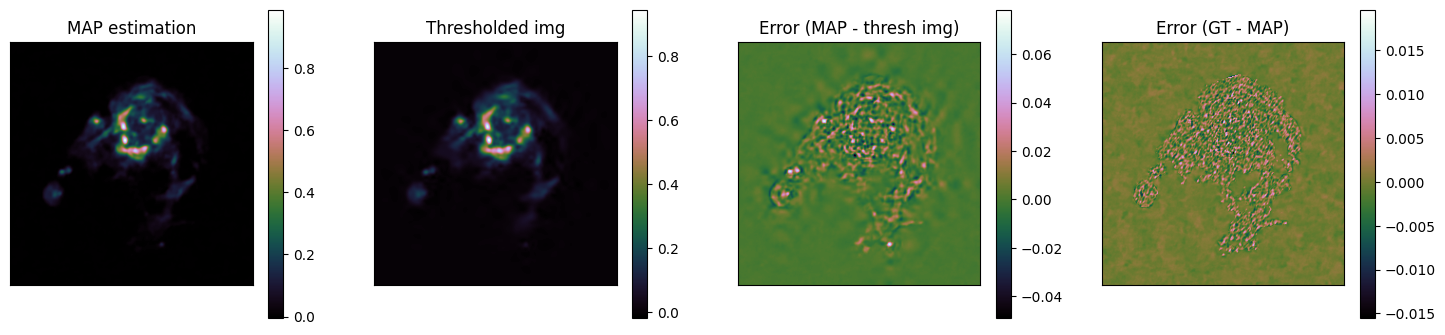

In [190]:
plt.figure(figsize=(18,4))

plt.subplot(141)
plt.imshow(to_numpy(torch_img), cmap=cmap)
plt.colorbar()
plt.title('MAP estimation')
ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

plt.subplot(142)
plt.imshow(to_numpy(select_thresh_img), cmap=cmap)
plt.colorbar()
plt.title('Thresholded img')
ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

plt.subplot(143)
plt.imshow(to_numpy(torch_img - select_thresh_img), cmap=cmap)
plt.colorbar()
plt.title('Error (MAP - thresh img)')
ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

plt.subplot(144)
plt.imshow(np_x - np_x_hat, cmap=cmap)
plt.colorbar()
plt.title('Error (GT - MAP)')
ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

plt.show()




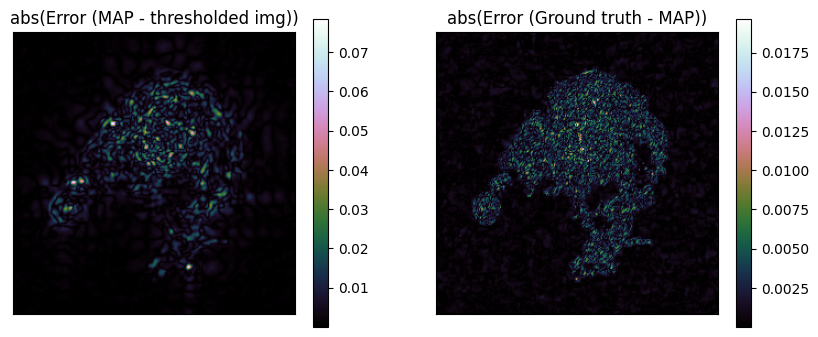

In [192]:

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.imshow(abs(to_numpy(torch_img - select_thresh_img)), cmap=cmap)
plt.colorbar()
plt.title('abs(Error (MAP - thresholded img))')
ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

plt.subplot(122)
plt.imshow(abs(np_x - np_x_hat), cmap=cmap)
plt.colorbar()
plt.title('abs(Error (Ground truth - MAP))')
ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

plt.show()




# Threshold every level

In [196]:
def _potential_to_bisect(val, level, fun_np, oper2wavelet, torch_img):

    return gamma_alpha - fun_np(
        oper2wavelet.full_op_threshold_img(torch_img, val, level)
    )



selected_mult_val_up:  0.1224517822265625
gamma_alpha:  100600.93884931403
MAP image:  32619.361328125
modified image up:  100572.90625


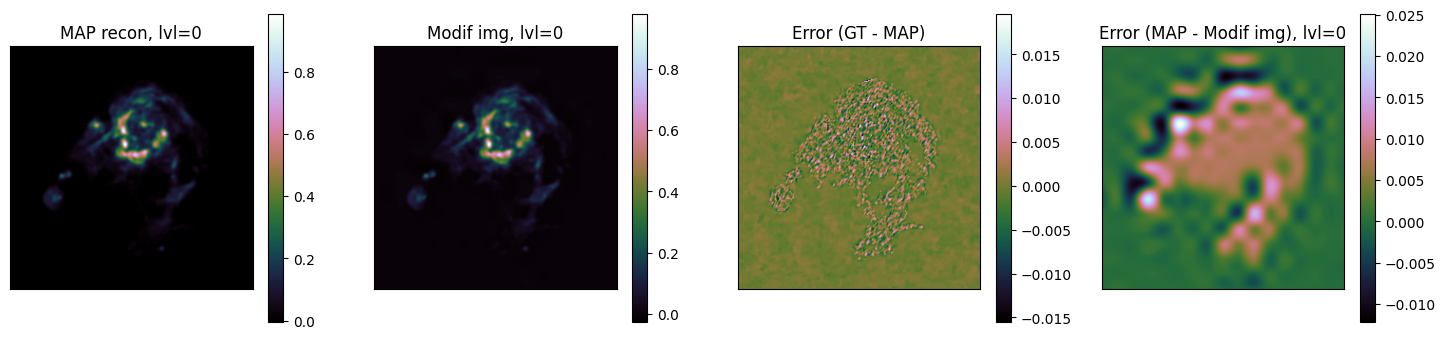

selected_mult_val_up:  0.0827789306640625
gamma_alpha:  100600.93884931403
MAP image:  32619.361328125
modified image up:  100597.828125


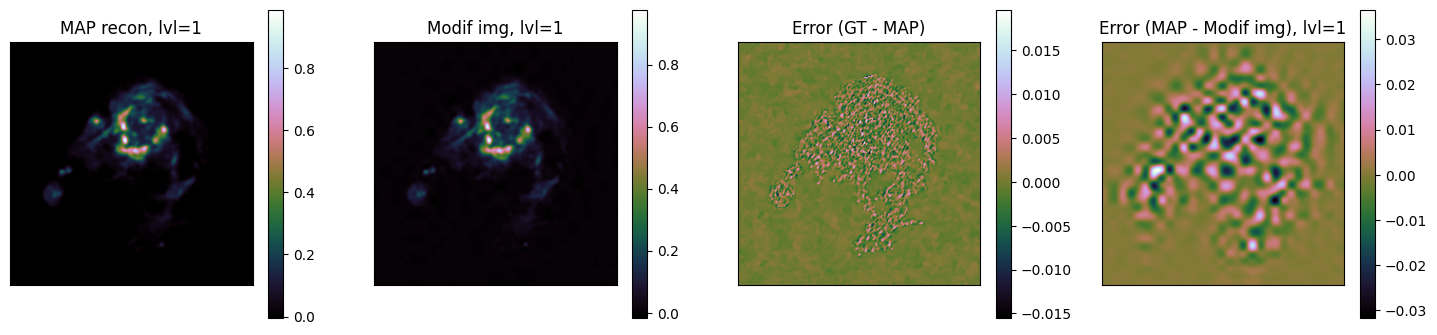

selected_mult_val_up:  0.06565093994140625
gamma_alpha:  100600.93884931403
MAP image:  32619.361328125
modified image up:  100584.6171875


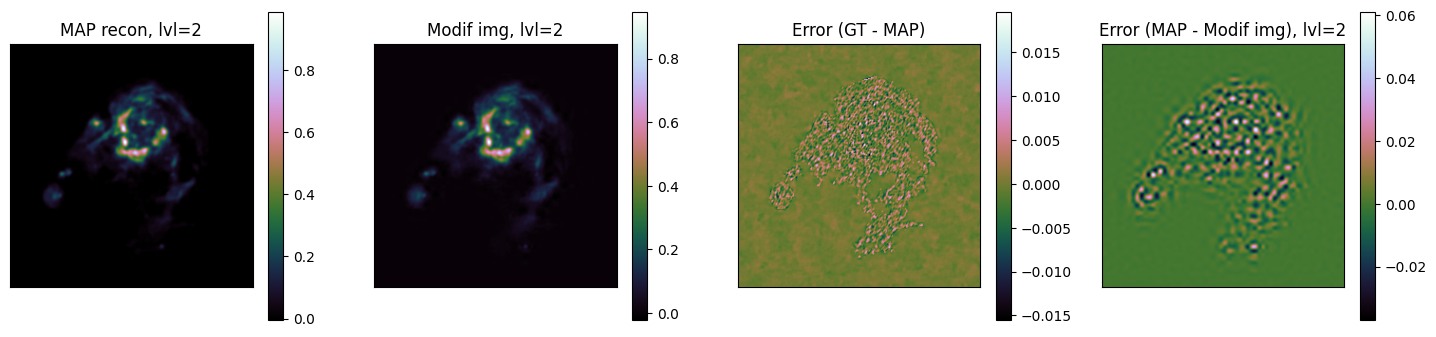

selected_mult_val_up:  0.209503173828125
gamma_alpha:  100600.93884931403
MAP image:  32619.361328125
modified image up:  100599.53125


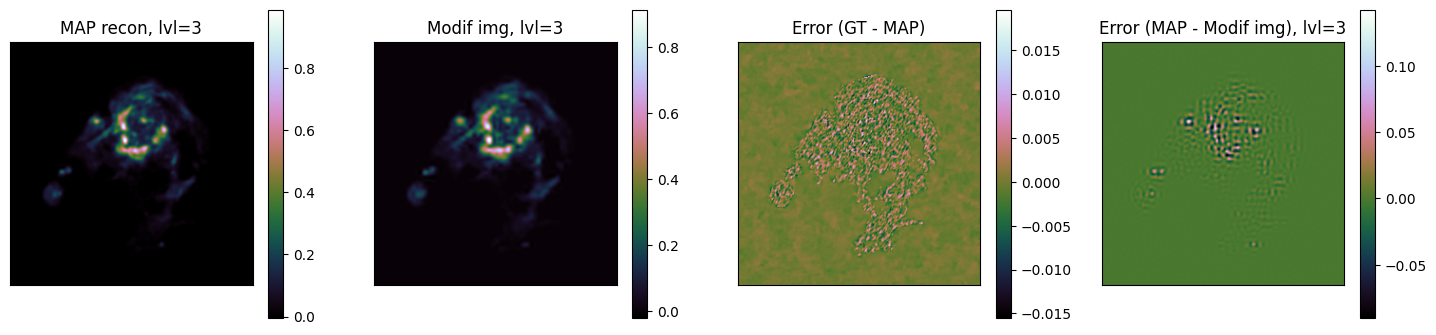

[Bisection Method] There is no root in this range.
selected_mult_val_up:  0
gamma_alpha:  100600.93884931403
MAP image:  32619.361328125
modified image up:  32619.361328125


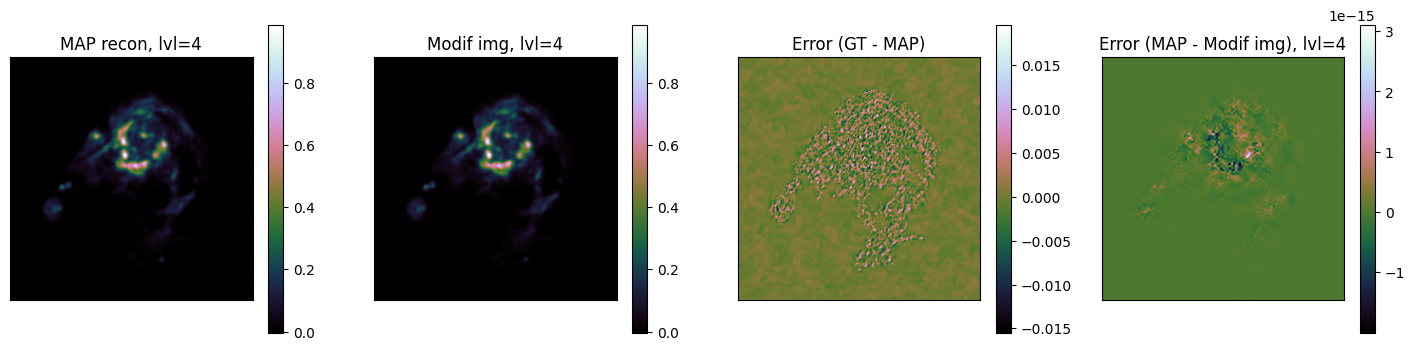

In [199]:
for test_level in range(5):


    # Evaluation of the potential
    potential_to_bisect = partial(
        _potential_to_bisect,
        level=test_level,
        fun_np=fun_np,
        oper2wavelet=oper2wavelet,
        torch_img=torch_img
    )

    # Upper value
    start_interval = [0, 10]
    iters = 1e3
    tol = 1e-3

    selected_thresh_val = luq.map_uncertainty.bisection_method(
        potential_to_bisect, start_interval, iters, tol
    )
    modified_img = oper2wavelet.full_op_threshold_img(torch_img, selected_thresh_val, test_level)
    
    print('selected_mult_val_up: ', selected_thresh_val)
    print('gamma_alpha: ', gamma_alpha)
    print('MAP image: ', fun_np(torch_img.squeeze()))
    print('modified image up: ', fun_np(modified_img))


    plt.figure(figsize=(18,4))

    plt.subplot(141)
    plt.imshow(to_numpy(torch_img), cmap=cmap)
    plt.colorbar()
    plt.title('MAP recon, lvl={:d}'.format(test_level))
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.subplot(142)
    plt.imshow(to_numpy(modified_img), cmap=cmap)
    plt.colorbar()
    plt.title('Modif img, lvl={:d}'.format(test_level))
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.subplot(143)
    plt.imshow(np_x - to_numpy(torch_img), cmap=cmap)
    plt.colorbar()
    plt.title('Error (GT - MAP)')
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.subplot(144)
    plt.imshow(to_numpy(torch_img - modified_img), cmap=cmap)
    plt.colorbar()
    plt.title('Error (MAP - Modif img), lvl={:d}'.format(test_level))
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])


    plt.show()



# Add constant valued to wavelet coefficients

In [201]:



def _potential_to_bisect(val, level, fun_np, oper2wavelet, torch_img):

    return gamma_alpha - fun_np(
        oper2wavelet.full_op_add_img(torch_img, val, level)
    )





selected_mult_val_up:  0.05527496337890625
gamma_alpha:  100600.93884931403
MAP image:  32619.361328125
modified image up:  100683.265625
selected_mult_val_up:  -0.05519866943359375
gamma_alpha:  100600.93884931403
MAP image:  32619.361328125
modified image up:  100521.1328125


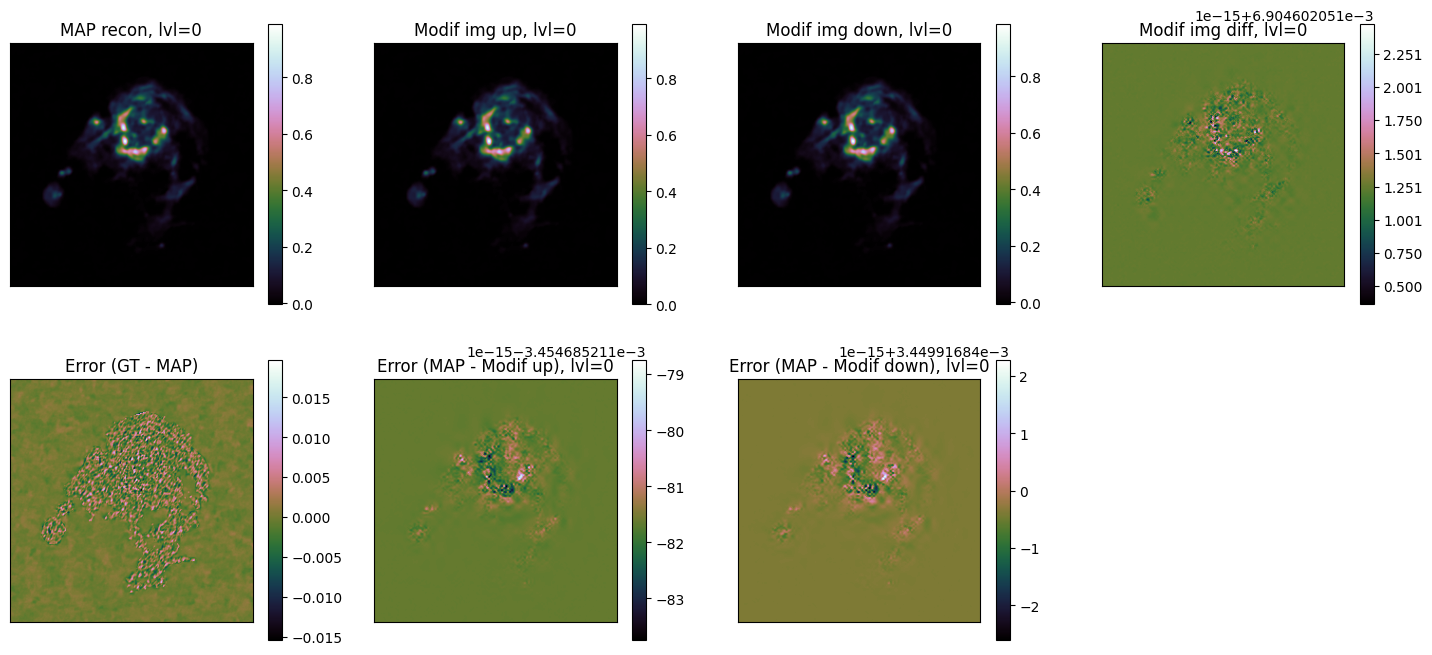

selected_mult_val_up:  0.04276275634765625
gamma_alpha:  100600.93884931403
MAP image:  32619.361328125
modified image up:  100716.171875
selected_mult_val_up:  -0.04276275634765625
gamma_alpha:  100600.93884931403
MAP image:  32619.361328125
modified image up:  100704.484375


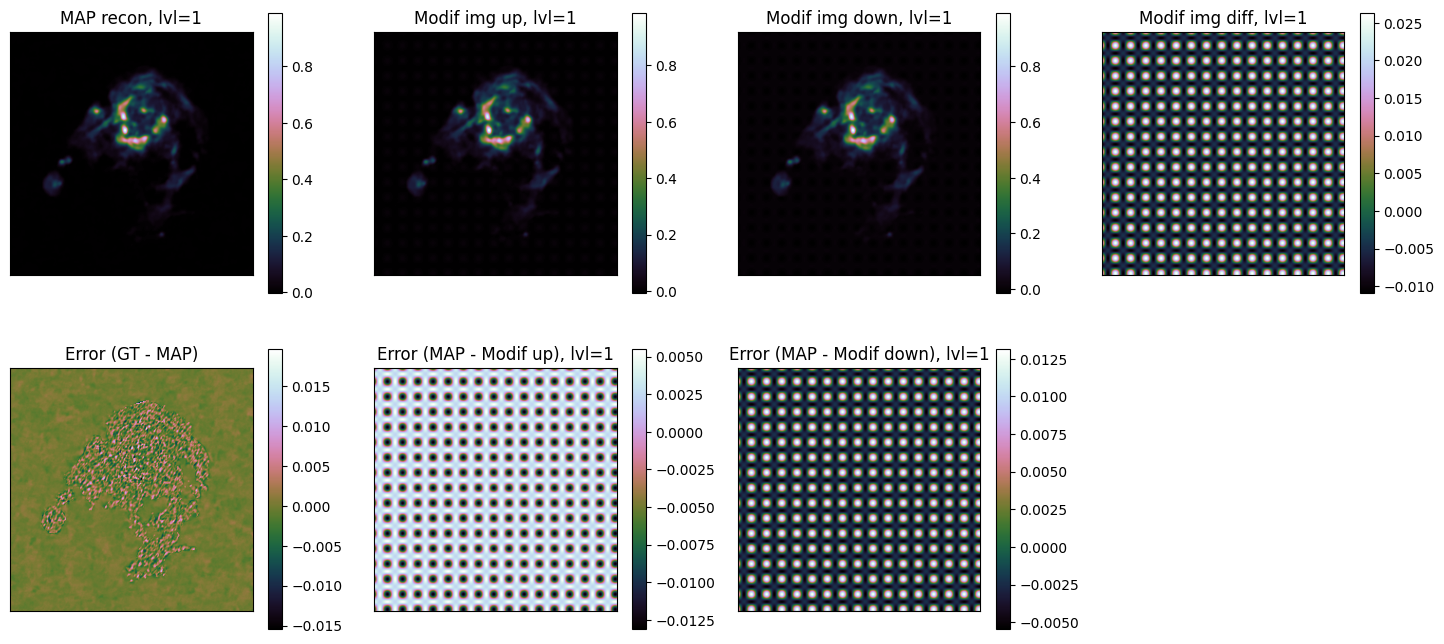

selected_mult_val_up:  0.023021697998046875
gamma_alpha:  100600.93884931403
MAP image:  32619.361328125
modified image up:  100631.875
selected_mult_val_up:  -0.023097991943359375
gamma_alpha:  100600.93884931403
MAP image:  32619.361328125
modified image up:  100690.546875


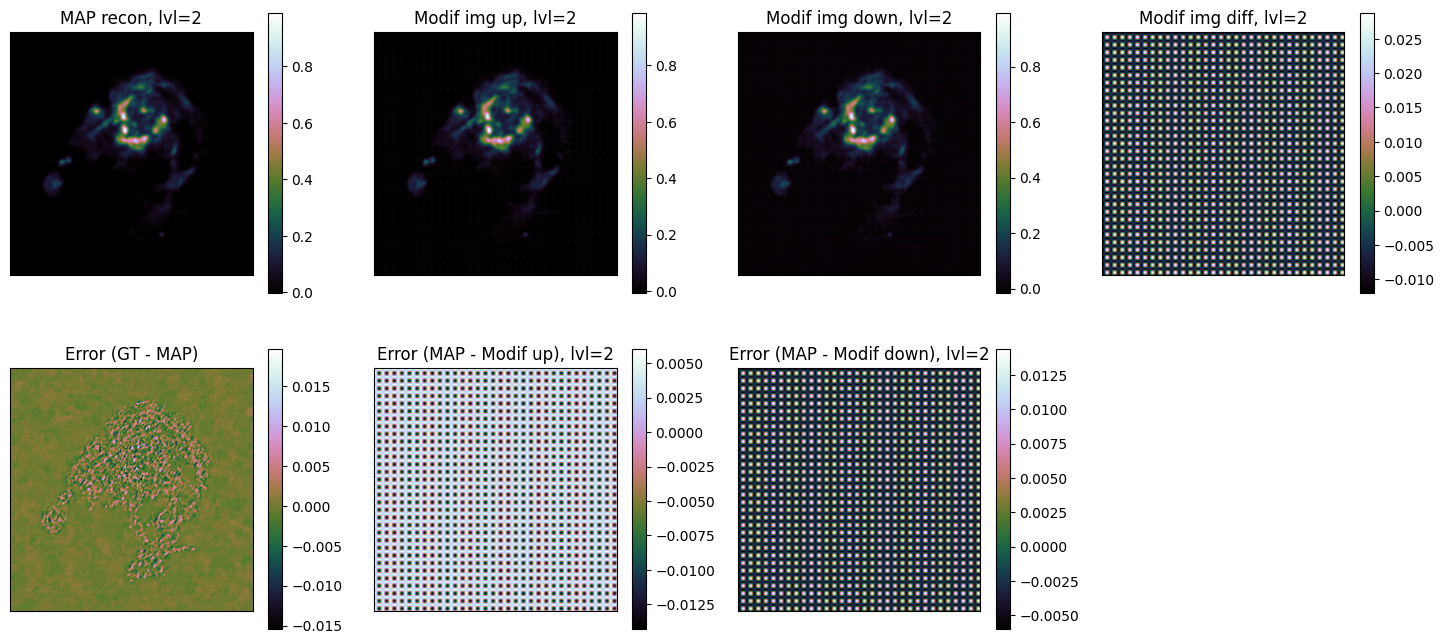

selected_mult_val_up:  0.016927719116210938
gamma_alpha:  100600.93884931403
MAP image:  32619.361328125
modified image up:  100598.3984375
selected_mult_val_up:  -0.016927719116210938
gamma_alpha:  100600.93884931403
MAP image:  32619.361328125
modified image up:  100640.265625


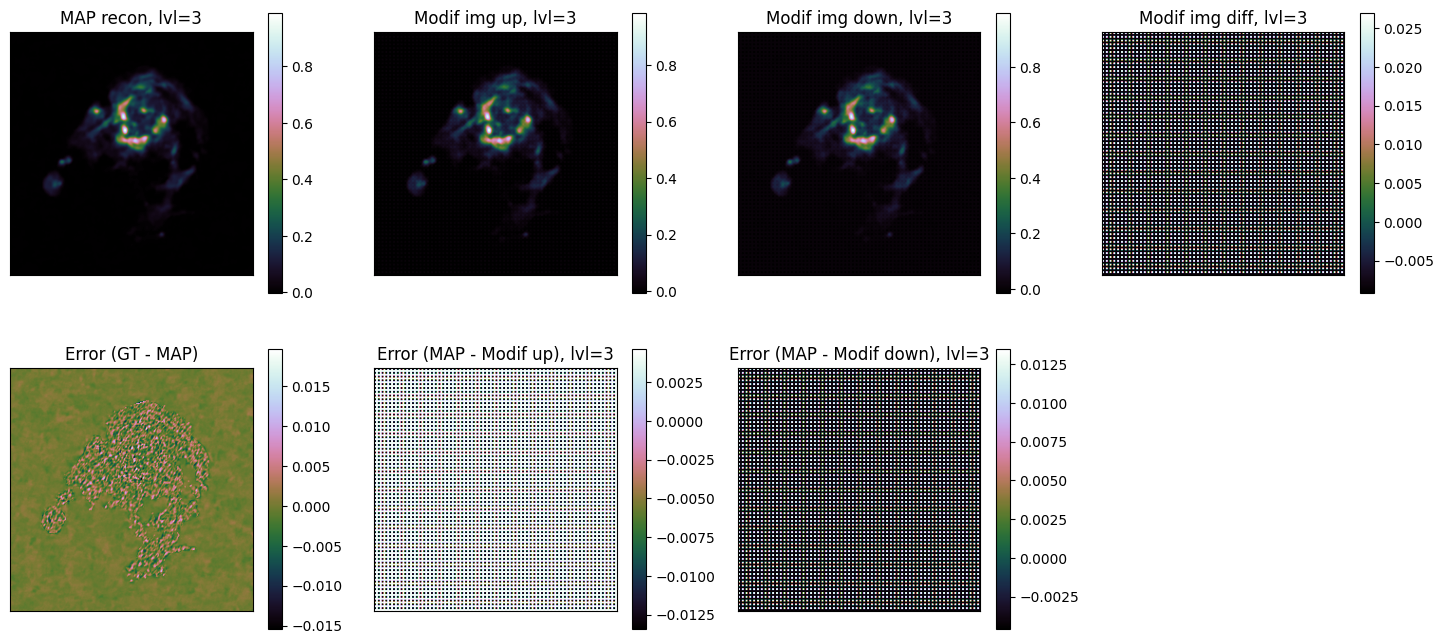

selected_mult_val_up:  0.006175041198730469
gamma_alpha:  100600.93884931403
MAP image:  32619.361328125
modified image up:  100573.3984375
selected_mult_val_up:  -0.006175041198730469
gamma_alpha:  100600.93884931403
MAP image:  32619.361328125
modified image up:  100606.1953125


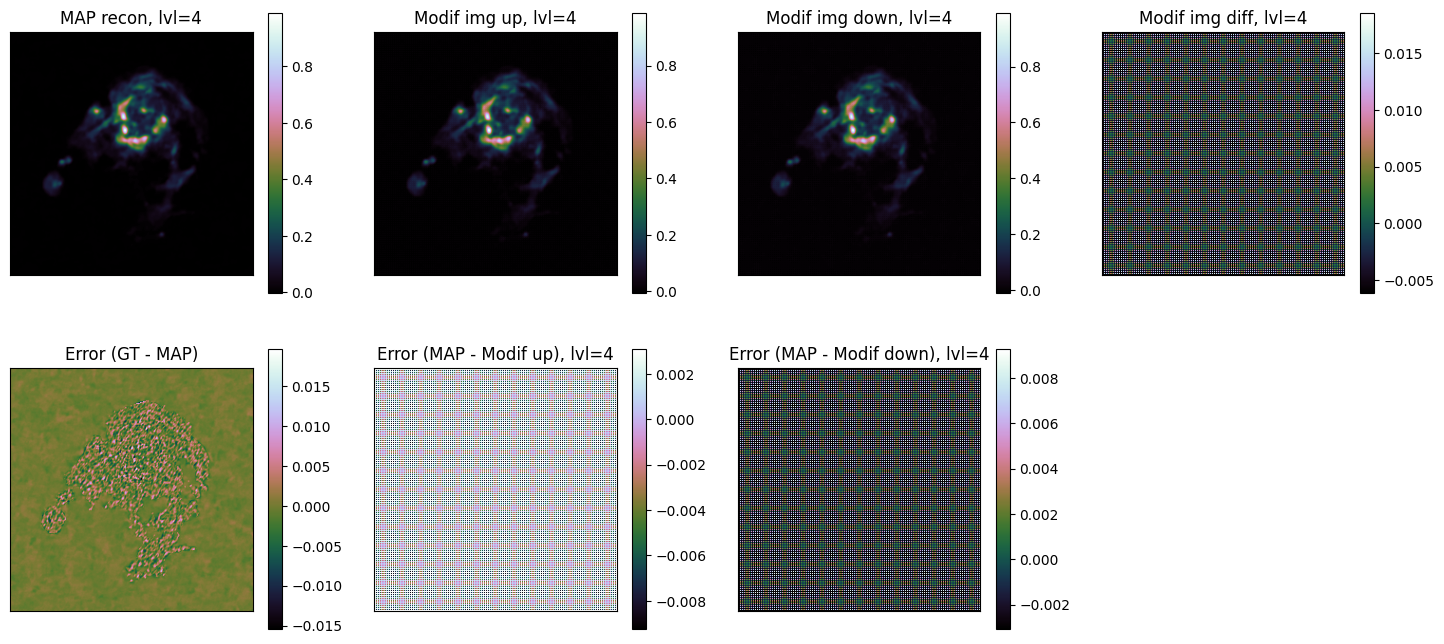

In [202]:

for test_level in range(5):


    # Evaluation of the potential
    potential_to_bisect = partial(
        _potential_to_bisect,
        level=test_level,
        fun_np=fun_np,
        oper2wavelet=oper2wavelet,
        torch_img=torch_img
    )

    # Upper value
    start_interval = [0, 20]
    iters = 1e3
    tol = 1e-3

    selected_add_val_up = luq.map_uncertainty.bisection_method(
        potential_to_bisect, start_interval, iters, tol
    )
    modified_img_up = oper2wavelet.full_op_add_img(torch_img, selected_add_val_up, test_level)
    
    print('selected_mult_val_up: ', selected_add_val_up)
    print('gamma_alpha: ', gamma_alpha)
    print('MAP image: ', fun_np(torch_img.squeeze()))
    print('modified image up: ', fun_np(modified_img_up))


    # Down value
    start_interval = [-20, 0]
    iters = 1e3
    tol = 1e-3

    selected_add_val_down = luq.map_uncertainty.bisection_method(
        potential_to_bisect, start_interval, iters, tol
    )
    modified_img_down = oper2wavelet.full_op_add_img(torch_img, selected_add_val_down, test_level)
    
    print('selected_mult_val_up: ', selected_add_val_down)
    print('gamma_alpha: ', gamma_alpha)
    print('MAP image: ', fun_np(torch_img.squeeze()))
    print('modified image up: ', fun_np(modified_img_down))

    # Compute difference image
    modified_img_diff = modified_img_up - modified_img_down


    plt.figure(figsize=(18,8))

    plt.subplot(241)
    plt.imshow(to_numpy(torch_img), cmap=cmap)
    plt.colorbar()
    plt.title('MAP recon, lvl={:d}'.format(test_level))
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.subplot(242)
    plt.imshow(to_numpy(modified_img_up), cmap=cmap)
    plt.colorbar()
    plt.title('Modif img up, lvl={:d}'.format(test_level))
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.subplot(243)
    plt.imshow(to_numpy(modified_img_down), cmap=cmap)
    plt.colorbar()
    plt.title('Modif img down, lvl={:d}'.format(test_level))
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.subplot(244)
    plt.imshow(to_numpy(modified_img_diff), cmap=cmap)
    plt.colorbar()
    plt.title('Modif img diff, lvl={:d}'.format(test_level))
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.subplot(245)
    plt.imshow(np_x - to_numpy(torch_img), cmap=cmap)
    plt.colorbar()
    plt.title('Error (GT - MAP)')
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.subplot(246)
    plt.imshow(to_numpy(torch_img - modified_img_up), cmap=cmap)
    plt.colorbar()
    plt.title('Error (MAP - Modif up), lvl={:d}'.format(test_level))
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.subplot(247)
    plt.imshow(to_numpy(torch_img - modified_img_down), cmap=cmap)
    plt.colorbar()
    plt.title('Error (MAP - Modif down), lvl={:d}'.format(test_level))
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.show()





# Multiply valued to wavelet coefficients

In [167]:
def _potential_to_bisect(val, level, fun_np, oper2wavelet, torch_img):

    return gamma_alpha - fun_np(
        oper2wavelet.full_op_mult_img(torch_img, val, level)
    )





selected_mult_val_up:  1.06494140625
gamma_alpha:  100600.93884931403
MAP image:  32619.361328125
modified image up:  91888.28125
selected_mult_val_up:  0.9296875
gamma_alpha:  100600.93884931403
MAP image:  32619.361328125
modified image up:  102094.7890625


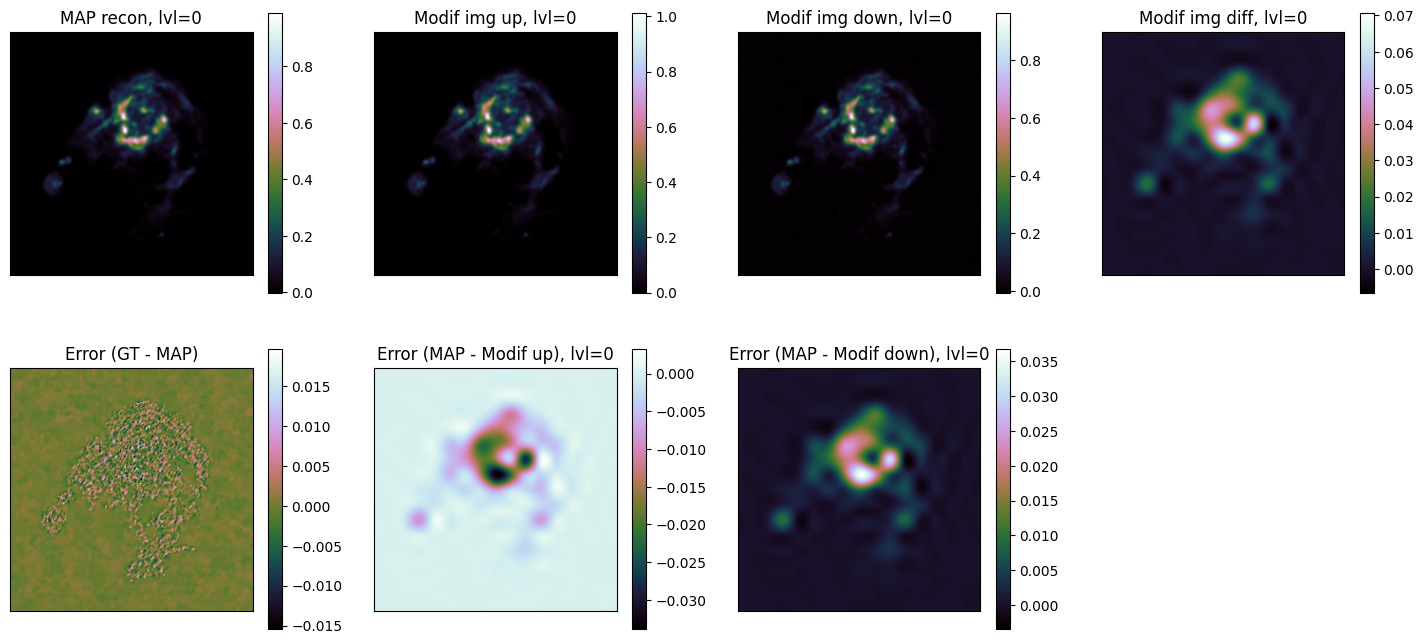

selected_mult_val_up:  1.19482421875
gamma_alpha:  100600.93884931403
MAP image:  32619.361328125
modified image up:  98246.0234375
selected_mult_val_up:  0.8046875
gamma_alpha:  100600.93884931403
MAP image:  32619.361328125
modified image up:  98601.7734375


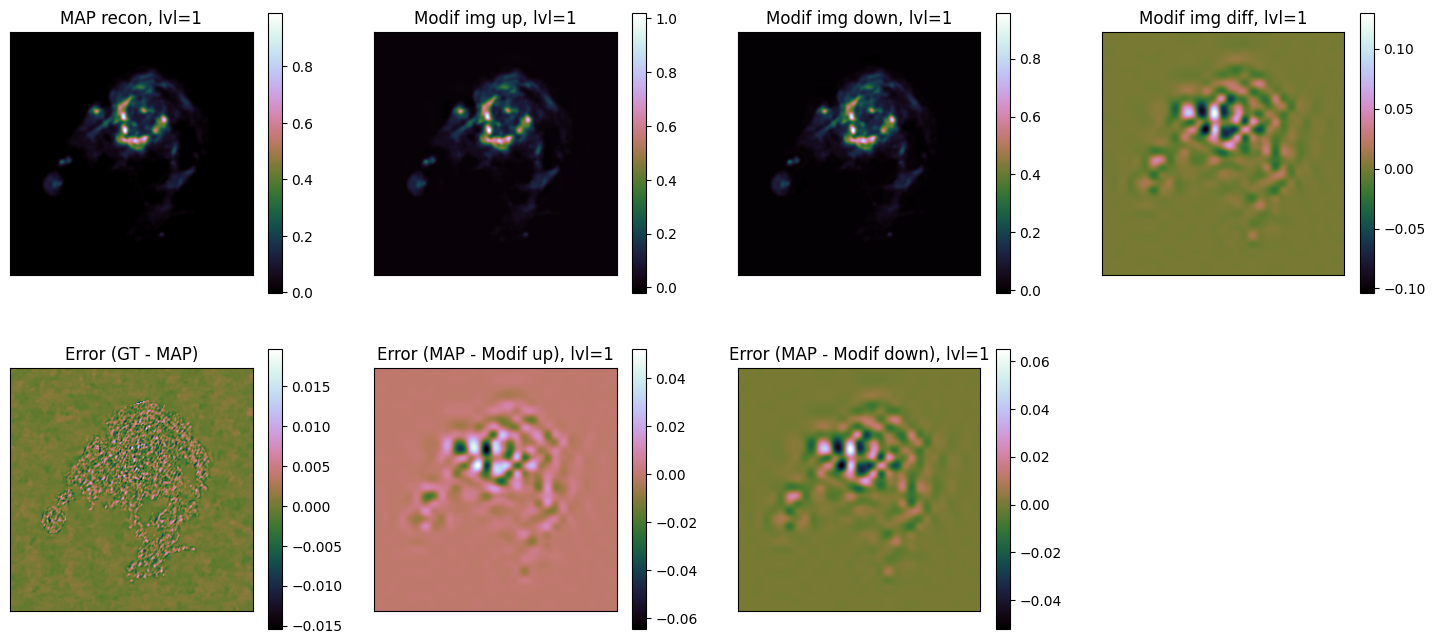

selected_mult_val_up:  1.28759765625
gamma_alpha:  100600.93884931403
MAP image:  32619.361328125
modified image up:  100955.1171875
selected_mult_val_up:  0.71484375
gamma_alpha:  100600.93884931403
MAP image:  32619.361328125
modified image up:  99908.015625


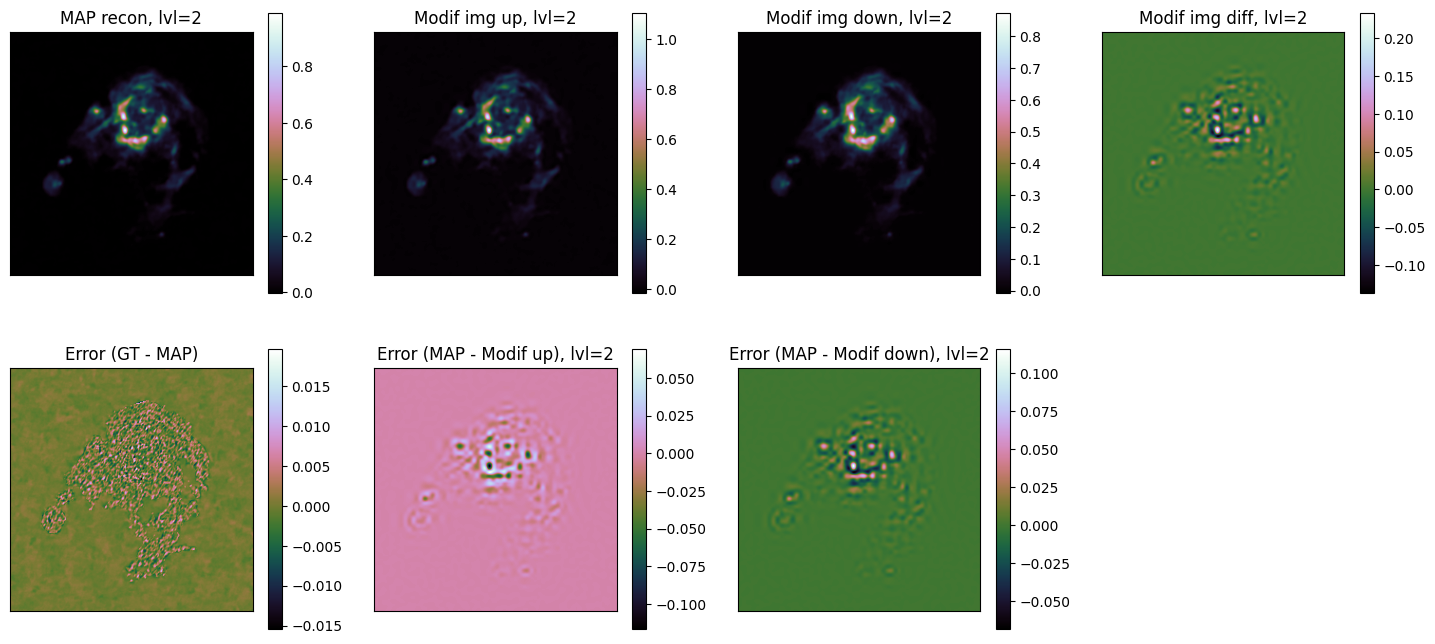

selected_mult_val_up:  1.9833984375
gamma_alpha:  100600.93884931403
MAP image:  32619.361328125
modified image up:  101703.2890625
selected_mult_val_up:  0.031494140625
gamma_alpha:  100600.93884931403
MAP image:  32619.361328125
modified image up:  100633.03125


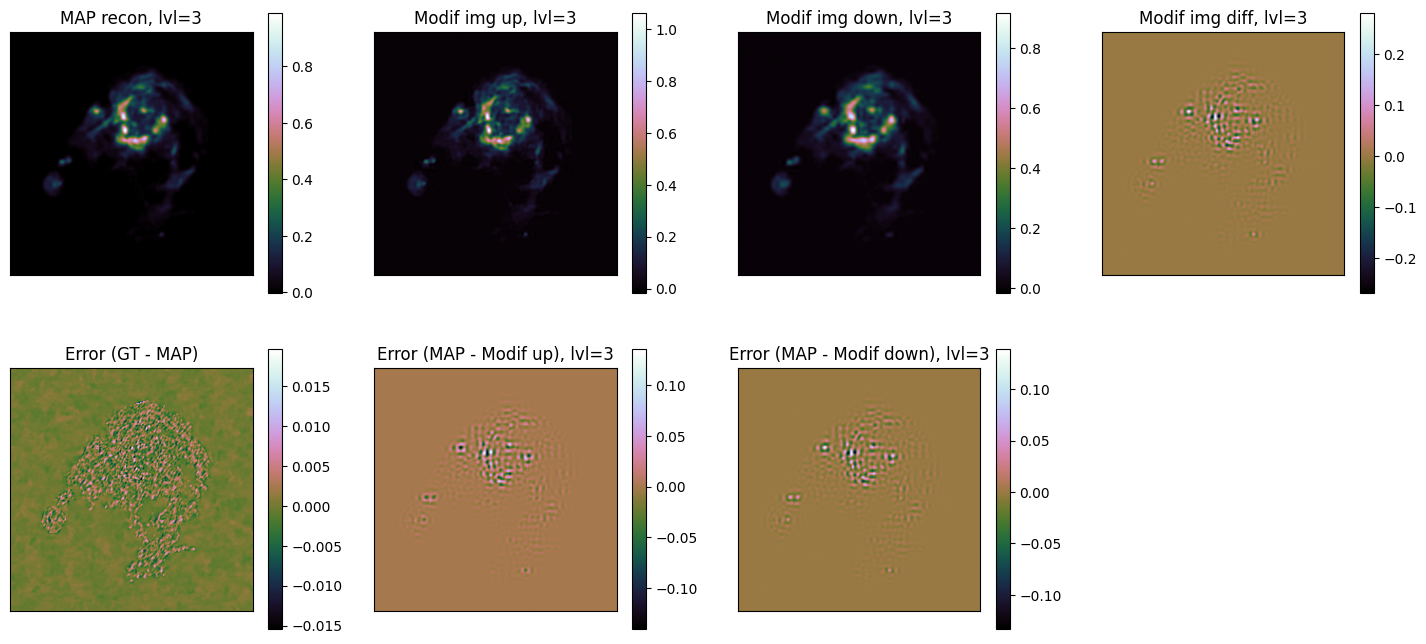

selected_mult_val_up:  9.83203125
gamma_alpha:  100600.93884931403
MAP image:  32619.361328125
modified image up:  101074.9375
[Bisection Method] There is no root in this range.
selected_mult_val_up:  0
gamma_alpha:  100600.93884931403
MAP image:  32619.361328125
modified image up:  33984.28515625


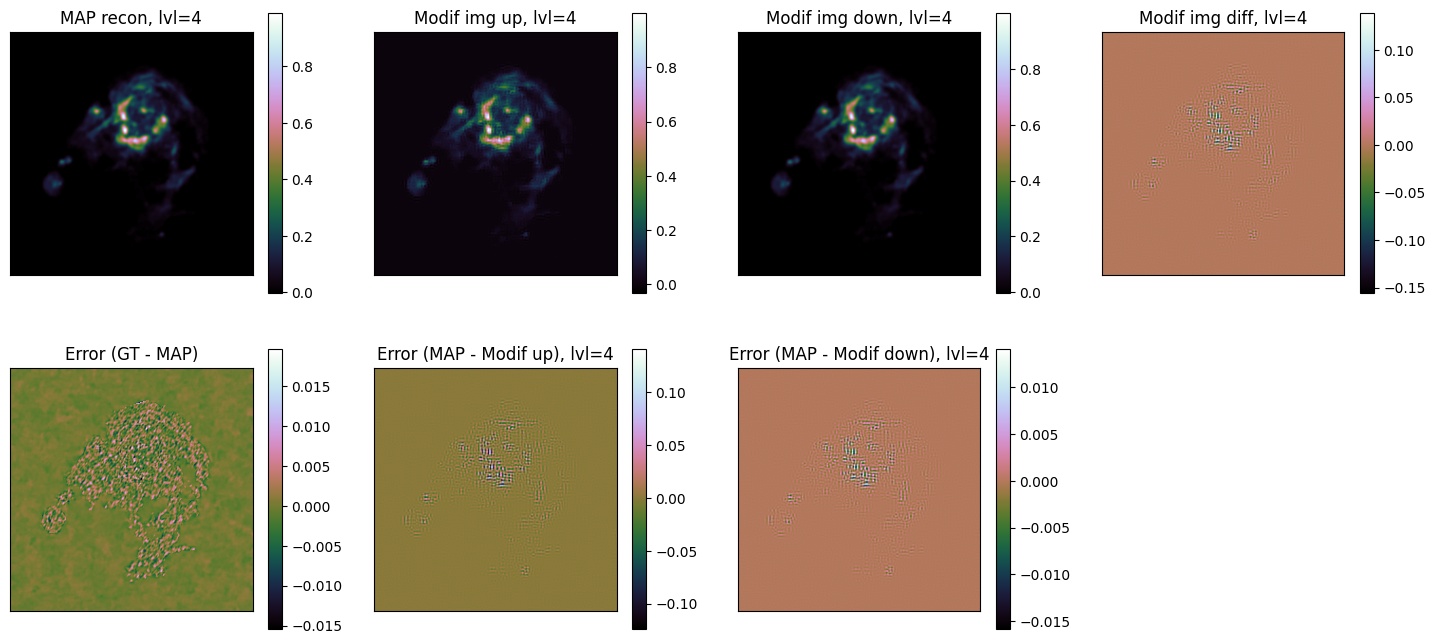

In [176]:
for test_level in range(5):


    # Evaluation of the potential
    potential_to_bisect = partial(
        _potential_to_bisect,
        level=test_level,
        fun_np=fun_np,
        oper2wavelet=oper2wavelet,
        torch_img=torch_img
    )

    # Upper value
    start_interval = [1, 20]
    iters = 5e2
    tol = 1e-2

    selected_mult_val_up = luq.map_uncertainty.bisection_method(
        potential_to_bisect, start_interval, iters, tol
    )
    modified_img_up = oper2wavelet.full_op_mult_img(torch_img, selected_mult_val_up, test_level)
    
    print('selected_mult_val_up: ', selected_mult_val_up)
    print('gamma_alpha: ', gamma_alpha)
    print('MAP image: ', fun_np(torch_img.squeeze()))
    print('modified image up: ', fun_np(modified_img_up))


    # Down value
    start_interval = [0, 1]
    iters = 5e2
    tol = 1e-2

    selected_mult_val_down = luq.map_uncertainty.bisection_method(
        potential_to_bisect, start_interval, iters, tol
    )
    modified_img_down = oper2wavelet.full_op_mult_img(torch_img, selected_mult_val_down, test_level)
    
    print('selected_mult_val_up: ', selected_mult_val_down)
    print('gamma_alpha: ', gamma_alpha)
    print('MAP image: ', fun_np(torch_img.squeeze()))
    print('modified image up: ', fun_np(modified_img_down))

    # Compute difference image
    modified_img_diff = modified_img_up - modified_img_down


    plt.figure(figsize=(18,8))

    plt.subplot(241)
    plt.imshow(to_numpy(torch_img), cmap=cmap)
    plt.colorbar()
    plt.title('MAP recon, lvl={:d}'.format(test_level))
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.subplot(242)
    plt.imshow(to_numpy(modified_img_up), cmap=cmap)
    plt.colorbar()
    plt.title('Modif img up, lvl={:d}'.format(test_level))
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.subplot(243)
    plt.imshow(to_numpy(modified_img_down), cmap=cmap)
    plt.colorbar()
    plt.title('Modif img down, lvl={:d}'.format(test_level))
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.subplot(244)
    plt.imshow(to_numpy(modified_img_diff), cmap=cmap)
    plt.colorbar()
    plt.title('Modif img diff, lvl={:d}'.format(test_level))
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.subplot(245)
    plt.imshow(np_x - to_numpy(torch_img), cmap=cmap)
    plt.colorbar()
    plt.title('Error (GT - MAP)')
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.subplot(246)
    plt.imshow(to_numpy(torch_img - modified_img_up), cmap=cmap)
    plt.colorbar()
    plt.title('Error (MAP - Modif up), lvl={:d}'.format(test_level))
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.subplot(247)
    plt.imshow(to_numpy(torch_img - modified_img_down), cmap=cmap)
    plt.colorbar()
    plt.title('Error (MAP - Modif down), lvl={:d}'.format(test_level))
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.show()

